In [1]:
using Distributions
using LinearAlgebra
using Plots
using LaTeXStrings
using Distributed

In [3]:
addprocs()

8-element Vector{Int64}:
 2
 3
 4
 5
 6
 7
 8
 9

In [11]:
@everywhere include("../testfns.jl")
@everywhere include("../rollout.jl")
@everywhere include("../utils.jl")

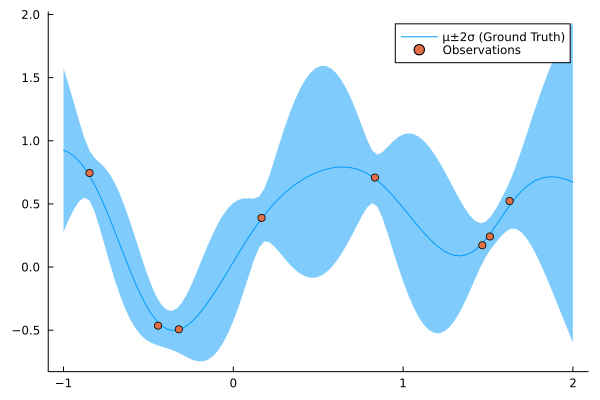

In [23]:
MC_SAMPLES = 50
NUMBER_OF_STARTS = 24
NUMBER_OF_TRIALS = 1
HORIZON = 0
BATCH_SIZE = 8
USE_LDS = true
INITIAL_SAMPLES = 8

# Gaussian process hyperparameters
θ, σn2 = [1.], 1e-2
ψ = kernel_matern52(θ)
testfn = TestLinearCosine1D(1., 6.2)
testfn = TestFunction(
    1, [-1. 2.], (zeros(1),),
    x -> sin(3first(x)) + first(x)^2 - .7first(x),
    x -> [0.]
)
lbs, ubs = testfn.bounds[:, 1], testfn.bounds[:, 2]

# Generate low discrepancy sequence
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON + 1)
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

# Allocate initial guesses for optimizer
initial_guesses = generate_initial_guesses(NUMBER_OF_STARTS, lbs, ubs)

# Allocate all initial samples
initial_samples = randsample(NUMBER_OF_TRIALS, testfn.dim, lbs, ubs)

# Initialize the trajectory parameters
tp = TrajectoryParameters(
    initial_samples[:, 1], # Will be overriden later
    HORIZON,
    MC_SAMPLES,
    USE_LDS ? lds_rns : rns,
    lbs,
    ubs,
)

# Initialize batch of points to evaluate the rollout acquisition function
batch = generate_batch(BATCH_SIZE, lbs=tp.lbs, ubs=tp.ubs)

# Initialize shared memory for solving base policy in parallel
candidate_locations = SharedMatrix{Float64}(testfn.dim, NUMBER_OF_STARTS)
candidate_values = SharedArray{Float64}(NUMBER_OF_STARTS)

trial = first(rand(1:NUMBER_OF_TRIALS, 1))
Xinit = randsample(INITIAL_SAMPLES, testfn.dim, lbs, ubs)
# Xinit = [.5;; .47;; 1.2;; -.2;; -.85;; 1.6;; 1.7;; 1.78;; 1.81;; 1.89;;]
yinit = testfn.f.(eachcol(Xinit))
# sur = fit_surrogate(ψ, Xinit, yinit; σn2=σn2);
sur = optimize_hypers_optim(
    fit_surrogate(ψ, Xinit, yinit; σn2=σn2),
    kernel_matern52
);
plot1D(sur, xmin=first(lbs), xmax=first(ubs))

## The Knowledge Gradient Acquisition Function

In [50]:
function knowledge_gradient_constructor(s::RBFsurrogate, lbs, ubs; guesses, M)
    stdnormals = randn(length(lbs) + 1, M)
    xmini, μ0 = get_minimum(s, lbs, ubs, guesses=guesses)
    
    function knowledge_gradient(x)
        μnext = zeros(M)
        fsur = fit_fsurrogate(s, 0)

        for i in 1:M
            # Update surrogate and compute new minimum for predictive mean
            # fsur = fit_fsurrogate(s, 0)
            update_fsurrogate!(fsur, x, gp_draw(s, x, stdnormal=stdnormals[1, i]))
            μnext[i] = get_minimum(fsur, lbs, ubs, guesses=guesses)[2]
            reset_fsurrogate!(fsur, s)
        end

        return -sum(μ0 .- μnext) / M
    end

    return knowledge_gradient
end


function knowledge_gradient_solver(s::RBFsurrogate, lbs, ubs; initial_guesses, M=100)
    kgx = knowledge_gradient_constructor(s, lbs, ubs, guesses=initial_guesses, M=M)

    final_minimizer = (initial_guesses[:, 1], Inf)
    for j in 1:size(initial_guesses, 2)
        print("|")
        guess = initial_guesses[:, j]
        result = optimize(
            kgx,
            lbs, ubs, guess,
            Fminbox(LBFGS(linesearch=Optim.LineSearches.BackTracking(order=2))),
            Optim.Options(x_tol=1e-3, f_tol=1e-3, time_limit=3.)
            # lbs, ubs, guess, Fminbox(NelderMead()), Optim.Options(x_tol=1e-3, f_tol=1e-3)
        )
        cur_minimizer, cur_minimum = Optim.minimizer(result), Optim.minimum(result)

        if cur_minimum < final_minimizer[2]
            final_minimizer = (cur_minimizer, cur_minimum)
        end
    end

    return final_minimizer
end

@everywhere function dknowledge_gradient_solver(s::RBFsurrogate, lbs, ubs; initial_guesses, M=100)
    kgx = knowledge_gradient_constructor(s, lbs, ubs, guesses=initial_guesses, M=M)
    
    d, N = size(initial_guesses)
    candidate_minimizers = SharedMatrix{Float64}(d, N)
    candidate_minimums = SharedArray{Float64}(N)

    @sync @distributed for j in 1:size(initial_guesses, 2)
        print("|")
        guess = initial_guesses[:, j]
        result = optimize(
            kgx,
            lbs, ubs, guess,
            Fminbox(LBFGS(linesearch=Optim.LineSearches.BackTracking(order=2))),
            Optim.Options(x_tol=1e-3, f_tol=1e-3, time_limit=3.)
        )
        candidate_minimizers[:, j] = Optim.minimizer(result)
        candidate_minimums[j] = Optim.minimum(result)
    end
    
    mini_value, index = findmin(candidate_minimums)
    minimizer = candidate_minimizers[:, index]

    return (minimizer, mini_value)
end


In [51]:
kg = knowledge_gradient_constructor(sur, lbs, ubs, guesses=initial_guesses, M=64);
# fd_dkg(x) = centered_fd(kg, [x], [1.], 1e-6)
domain = first(lbs):.01:first(ubs)
kgx = [kg([x]) for x in domain];

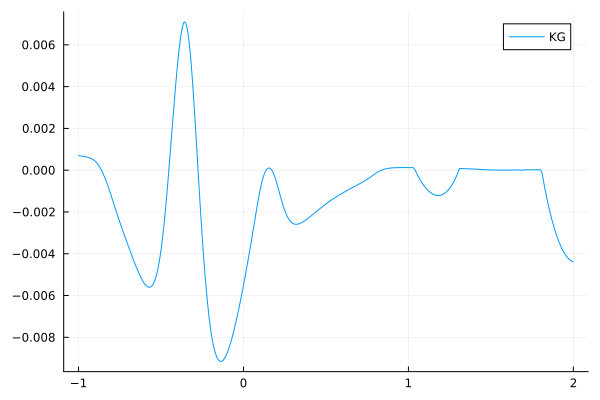

In [52]:
plot(domain, kgx, label="KG")

In [53]:
@time kg_solve = knowledge_gradient_solver(sur, lbs, ubs, initial_guesses=initial_guesses, M=64);

||||||||||||||||||||||||||156.100746 seconds (2.63 G allocations: 130.629 GiB, 16.86% gc time, 0.43% compilation time)


In [54]:
@time kg_solve2 = dknowledge_gradient_solver(sur, lbs, ubs, initial_guesses=initial_guesses, M=64);

 34.291719 seconds (183.13 k allocations: 10.984 MiB, 0.17% compilation time)


In [55]:
kg_solve

([-0.14249418827156338], -0.020092563885180652)

In [56]:
kg_solve2

([-0.15394046856684174], -0.02734407896352163)

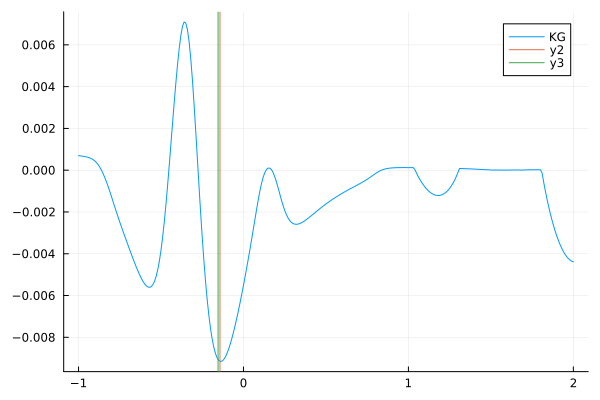

In [57]:
vline!(kg_solve[1])
vline!(kg_solve2[1])